In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
import seaborn as sns

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

# Read scenario data

Refer to **read_data.ipynb** for insight regarding how the data is generated and structured.

In [2]:
with open('Data/ALL_scenarios.json') as f:
    all_scenarios = json.load(f)

all_scenarios.keys()

dict_keys(['Sample Scenarios', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '

Set up constants

In [3]:
OMEGA = 250 # number of scenarios to sample
PI = 1 / OMEGA # probability of each sampled scenario - assumed to be equal

S = len(all_scenarios.keys()) - 1 # number of total scenarios
T = 24 # number of hours

WIND_CAPACITY = 200 #MWh

Randomly sample scenarios without replacement

In [4]:
import random
random.seed(123)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(S), 250)

print(in_sample_scenarios)

[107, 548, 178, 1574, 834, 545, 220, 1717, 1845, 1791, 78, 776, 1098, 1151, 680, 697, 1745, 106, 326, 276, 690, 1148, 683, 1437, 502, 335, 3, 1855, 893, 1584, 179, 1799, 1223, 773, 143, 13, 646, 1499, 918, 208, 1854, 89, 189, 1366, 291, 258, 1618, 1856, 43, 597, 1866, 881, 1174, 976, 543, 961, 1715, 75, 624, 703, 1068, 1641, 989, 423, 1681, 1247, 1308, 1079, 1156, 1657, 1967, 645, 25, 815, 1828, 1575, 1323, 1050, 889, 1402, 1102, 1307, 1631, 1365, 1221, 1822, 1707, 995, 1066, 1369, 859, 767, 1044, 65, 1735, 1544, 1321, 371, 1486, 1679, 169, 1871, 997, 1347, 536, 348, 685, 1135, 801, 1810, 150, 1480, 935, 793, 1173, 1594, 688, 33, 387, 1200, 180, 1703, 1286, 744, 26, 1835, 720, 469, 830, 1089, 1026, 1482, 1687, 1861, 122, 589, 1013, 1974, 1565, 1290, 1475, 477, 1114, 990, 363, 314, 910, 775, 1539, 944, 90, 20, 275, 934, 395, 525, 1636, 556, 1955, 1298, 860, 0, 222, 1264, 128, 1045, 727, 1448, 181, 887, 1838, 17, 1629, 1097, 1119, 1421, 1300, 827, 59, 660, 537, 1957, 967, 67, 1537, 1150,

Extract in-sample scenarios

In [5]:
scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(len(in_sample_scenarios)):
    scenarios[str(i)] = all_scenarios[str(in_sample_scenarios[i])]
    scenarios[str(i)]['Original Index'] = in_sample_scenarios[i]
    
print('Number of extracted scenarios:', len(scenarios))

Number of extracted scenarios: 250


# One-price Scheme

*(Task 1.a)*

## Run model

In [6]:
def solve_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA):
    direction = gb.GRB.MAXIMIZE #Min / Max

    m = gb.Model() # Create a Gurobi model  
    m.setParam('OutputFlag', 0)

    #============= Variables =============
    p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid
    delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
    price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K") # price coefficient for the imbalance price wrt. the day-ahead price

    #============= Objective function =============
    # Set objective function - note that the day-ahead price is factored out of the sum
    obj = gb.quicksum(PI * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w]) for t in range(T) for w in range(OMEGA))
    m.setObjective(obj, direction)

    #============= Day-ahead power bid limits ============

    #Upper limit is the nominal wind power
    m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

    #============= Power imbalance definition (realized - bid) ===============
    m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

    #============= Price coefficient definition ===============
    # the system balance parameter is 0 if the system has a surplus and 1 if it has a deficit
    m.addConstrs(price_coeff[t,w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

    #============= Display and run model =============
    m.update()
    #m.display()
    m.optimize()

    #============= Results =============
    results = {}
    if m.status == gb.GRB.OPTIMAL:
        #initialization
        for scenario in range(OMEGA):
            df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State', 'Balancing Price Coefficient'])
            
            for t in range(T):
                df.loc[t] = [t, 
                            scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                            scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x, 
                            delta[t,scenario].x, scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                            price_coeff[t,scenario].x * scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * delta[t,scenario].x, 
                            scenarios[str(scenario)]['System Balance State'][t], price_coeff[t,scenario].x]
            df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

            df['Hour'] = df['Hour'].astype(int)
            df['System State'] = df['System State'].astype(int)
            df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
            df.set_index('Hour', inplace=True)
            results[scenario] = df.copy(deep=True)

        print('-----------------------------------------------')
        print('Objective value (expected profit): %.2f EUR' % m.objVal)
        print('-----------------------------------------------')
        print('Day-ahead bids:')
        average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

        summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State', 'Average Price Coefficient'])
        for t in range(T):
            summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]), np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)]), np.mean([price_coeff[t,w].x for w in range(OMEGA)])]

        summary['Hour'] = summary['Hour'].astype(int)
        summary.set_index('Hour', inplace=True)

        results['Summary'] = summary.copy(deep=True)

        for t in range(T):
            print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

        print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
        print('-----------------------------------------------')
        print('Runtime: %f ms' % (m.Runtime * 1e3))
        print('Number of variables: %d' % m.NumVars)
        print('Number of constraints: %d' % m.NumConstrs)
        return p_DA, results
    else:
        print("Optimization was not successful.")
        return None, None    


In [7]:
p_DA_op, results_op = solve_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA)
results_op['Summary']

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-28
-----------------------------------------------
Objective value (expected profit): 169945.65 EUR
-----------------------------------------------
Day-ahead bids:
Hour 0 | Bid: 0.00 MW | Average Profit: 6088.45 EUR
Hour 1 | Bid: 0.00 MW | Average Profit: 6201.17 EUR
Hour 2 | Bid: 0.00 MW | Average Profit: 5634.33 EUR
Hour 3 | Bid: 0.00 MW | Average Profit: 5337.31 EUR
Hour 4 | Bid: 0.00 MW | Average Profit: 4900.24 EUR
Hour 5 | Bid: 0.00 MW | Average Profit: 5310.14 EUR
Hour 6 | Bid: 200.00 MW | Average Profit: 6318.35 EUR
Hour 7 | Bid: 0.00 MW | Average Profit: 6812.61 EUR
Hour 8 | Bid: 200.00 MW | Average Profit: 7829.89 EUR
Hour 9 | Bid: 200.00 MW | Average Profit: 7963.48 EUR
Hour 10 | Bid: 0.00 MW | Average Profit: 7897.94 EUR
Hour 11 | Bid: 0.00 MW | Average Profit: 7727.32 EUR
Hour 12 | Bid: 0.00 MW | Average Profit: 7582.19 EUR
Hour 13 | Bid: 0.00 MW | Average Profit: 8043.39 EUR
Hour 14 | 

,DA Bid [MW],Average Profit [EUR],Average Wind [MW],Median Wind [MW],Average System State,Average Price Coefficient
Hour,,,,,,
0,0.0,6088.447046,75.971079,58.187117,0.624,1.0872
1,0.0,6201.167928,75.421622,58.491371,0.816,1.1448
2,0.0,5634.325847,74.729242,56.260609,0.612,1.0836
3,0.0,5337.310364,74.219424,60.798811,0.624,1.0872
4,0.0,4900.243826,73.432345,59.646459,0.380,1.0140
5,0.0,5310.138626,72.983684,64.686541,0.440,1.0320
6,200.0,6318.351520,72.050807,73.145411,0.184,0.9552
7,0.0,6812.609374,71.763649,73.439255,0.428,1.0284
8,200.0,7829.890960,72.011247,79.261132,0.244,0.9732


In [8]:
# Print results for scenario 3
print(results_op[3])

      DA Price [EUR/MWh]  Wind Power [MW]  DA Bid [MW]  Imbalance [MW]  \
Hour                                                                     
0              86.129997       103.608684          0.0      103.608684   
1              82.930000       114.242993          0.0      114.242993   
2              80.099998       116.373771          0.0      116.373771   
3              76.550003       121.443913          0.0      121.443913   
4              75.160004       127.794000          0.0      127.794000   
5              80.410004       136.871895          0.0      136.871895   
6              95.970001       140.803080        200.0      -59.196920   
7             106.949997       140.568575          0.0      140.568575   
8             121.500000       145.633920        200.0      -54.366080   
9             117.440002       148.877145        200.0      -51.122855   
10            109.970001       150.777894          0.0      150.777894   
11            102.750000       152.728

## Visualize results

Plot vs. average "system state" and median realized wind power

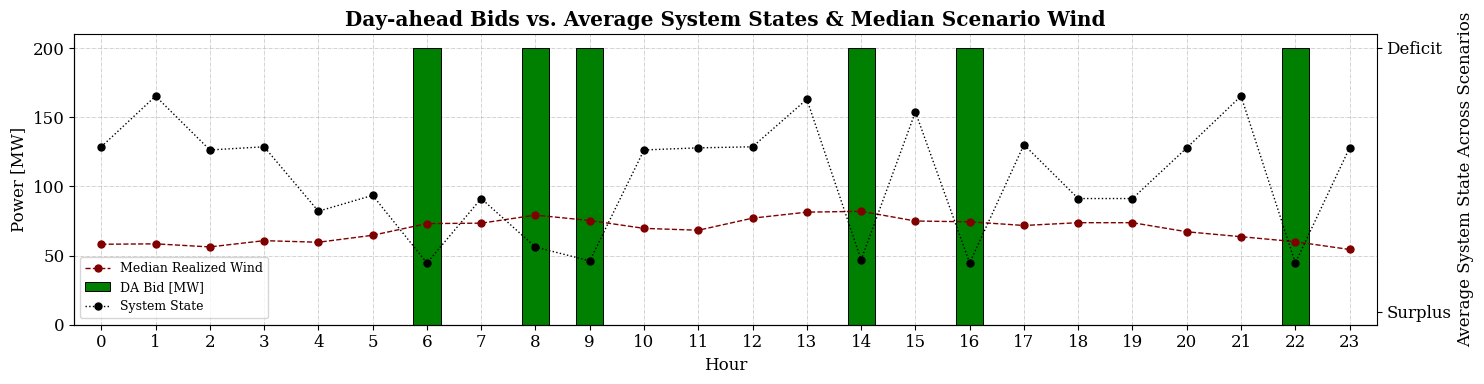

In [11]:
#DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(15, 4))
ax1 = fig.gca()

#plot day-ahead bid for each hour
results_op['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


#plot average "system state" for each hour
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

#create twinx
ax2 = ax1.twinx()

ax2.plot(average_system_state, color='black', linewidth=1, label='System State', marker='o', markersize=5, linestyle=':')

#plot median realized wind power across scenarios as black line
ax1.plot(results_op['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')

ax1.set_ylim([0, 1.05 * WIND_CAPACITY])

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower left', fontsize='9')

ax1.set_title('Day-ahead Bids vs. Average System States & Median Scenario Wind', weight='bold')
ax1.set_axisbelow(True)
ax2.grid(False)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2.set_ylim([-0.05,1.05])
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Surplus', 'Deficit'])

ax2.set_ylabel('Average System State Across Scenarios')

ax2.spines[['top','right']].set_visible(True)

fig.tight_layout()
#plt.savefig('Figures/One-price_BID_vs_SYSTEMSTATE_and_WIND.png', dpi=300, bbox_inches='tight')
plt.show()


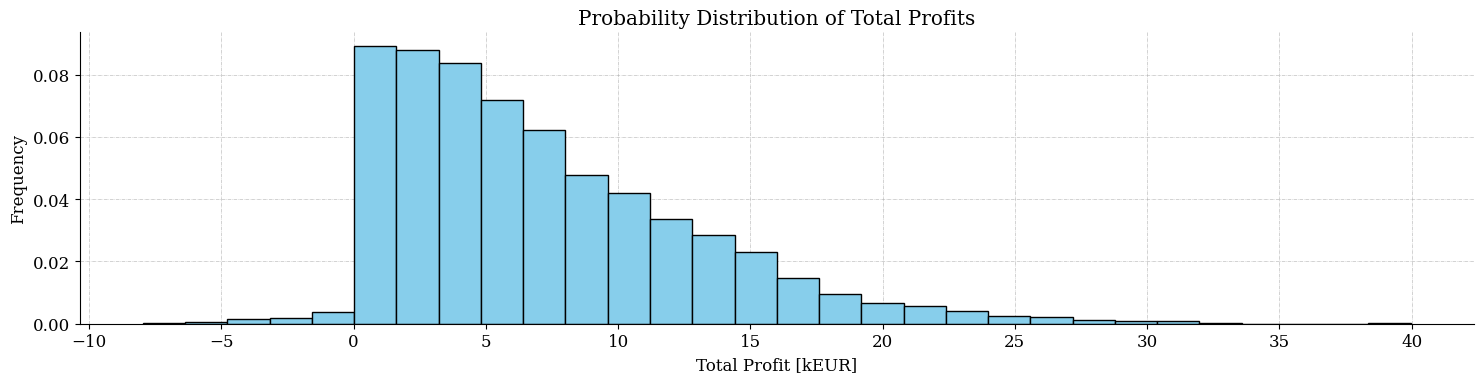

In [12]:
# total_profits = np.zeros((T, OMEGA))
# for w in range(OMEGA):
#     total_profits[:, w] = results_op[w]['Total Profit [EUR]']

# hourly_total_profits = np.sum(total_profits, axis=1)

# plt.figure(figsize=(10, 6))
# plt.hist(hourly_total_profits, bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.7)
# plt.title('Probability Distribution of Hourly Total Profits')
# plt.xlabel('Total Profit [EUR]')
# plt.ylabel('Probability Density')
# plt.grid(True)
# plt.show()

all_scenario_profits = []
for w in range(OMEGA):
    all_scenario_profits.extend(results_op[w]['Total Profit [EUR]'])

# Plot the probability distribution of profits for all scenarios
fig = plt.figure(figsize=(15, 4))
plt.hist(np.array(all_scenario_profits) * 1e-3, bins=30, density=True, color='skyblue', edgecolor='black', alpha=1)
plt.title('Probability Distribution of Total Profits')
plt.xlabel('Total Profit [kEUR]')
plt.ylabel('Frequency')
plt.xticks(np.arange(-10,45,5))
plt.grid(True)
plt.gca().set_axisbelow(True)
fig.tight_layout()
plt.savefig('Figures/PD in-sample OP.png', dpi=300, bbox_inches='tight')
plt.show()

<span style="color: red;">**Notes:**</span>
* Most places have one-price schemes now since it rewards those who help the system and penalizes those who don't, whereas the **two-price** scheme only punishes bad performance.
* The results seen in this optimization make sense when we can reliably predict if the system is in excess or deficit, but in reality you would want to bid closer to your expected production to avoid being penalized in the balancing market. **Maybe the results will be different if we use more scenarios?**
* Energinet generally does not have rules in place for how much imbalance you are allowed to be in - in other places, this can be punished to a larger degree.
* Behaviour will be dependent on scenario data, but wind tends to be pretty random.
* If we had a larger sample of "System State Scenarios" it might tend to be more balanced.

System State:
* 0 = Excess
* 1 = Deficit

When there is often a deficit (higher balancing price), it is seen to save the capacity until the balancing market.

# Two-price Scheme

*(Task 1.b)*

## Run model

In [14]:
OMEGA = len(scenarios.keys()) - 1 # number of scenarios
T = 24 # number of hours
PI = 1 / OMEGA # probability of each scenario - assumed to be equal
WIND_CAPACITY = 200 #MWh

In [15]:
def solve_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA):
    direction = gb.GRB.MAXIMIZE #Min / Max

    m = gb.Model() # Create a Gurobi model  

    m.setParam('OutputFlag', 0)

    #============= Variables =============
    p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid

    delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
    delta_up = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_up") # surplus
    delta_down = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="delta_down") # deficit

    imbalance_revenue = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="I") # imbalance revenue - can be negative

    # binary variables used to control the two-price logic
    y = m.addVars(T, OMEGA, vtype=gb.GRB.BINARY, name="y")
    z = m.addVars(4, T, OMEGA, vtype=gb.GRB.BINARY, name="z")

    #============= Objective function =============
    # Set objective function
    obj = gb.quicksum(PI * (scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * p_DA[t] + imbalance_revenue[t,w]) for t in range(T) for w in range(OMEGA))
    m.setObjective(obj, direction)

    #============= Day-ahead power bid limits ============

    #Upper limit is the nominal wind power
    m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

    #============= Power imbalance definitions ===============
    m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))
    m.addConstrs(delta[t,w] == delta_up[t,w] - delta_down[t,w] for t in range(T) for w in range(OMEGA))


    M = 1e6 # big-M constant
    #ensure that only one of the delta directions can be non-zero
    m.addConstrs(delta_up[t,w] <= M * (1 - y[t,w]) for t in range(T) for w in range(OMEGA))
    m.addConstrs(delta_down[t,w] <= M * y[t,w] for t in range(T) for w in range(OMEGA))

    #============= Linearized conditional statements ===============
    #Binary variable constraints
    m.addConstrs(z[0,t,w] <= y[t,w] + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
    m.addConstrs(z[1,t,w] <= y[t,w] + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))
    m.addConstrs(z[2,t,w] <= (1 - y[t,w]) + scenarios[str(w)]['System Balance State'][t] for t in range(T) for w in range(OMEGA))
    m.addConstrs(z[3,t,w] <= (1 - y[t,w]) + (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

    # if system is in a surplus and the imbalance is positive (NOT helping the system)
    m.addConstrs(imbalance_revenue[t,w] <= 0.9 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[0,t,w] for t in range(T) for w in range(OMEGA))

    # if system is in a deficit and the imbalance is positive (IS helping the system)
    m.addConstrs(imbalance_revenue[t,w] <= 1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_up[t,w] + M * z[1,t,w] for t in range(T) for w in range(OMEGA))

    # if system is in a surplus and the imbalance is negative (IS helping the system)
    m.addConstrs(imbalance_revenue[t,w] <= -1.0 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[2,t,w] for t in range(T) for w in range(OMEGA))

    # if system is in a deficit and the imbalance is negative (NOT helping the system)
    m.addConstrs(imbalance_revenue[t,w] <= -1.2 * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * delta_down[t,w] + M * z[3,t,w] for t in range(T) for w in range(OMEGA))

    #============= Display and run model =============
    m.update()
    #m.display()
    m.optimize()

    #============= Results =============
    results = {}
    if m.status == gb.GRB.OPTIMAL:
        #initialization
        for scenario in range(OMEGA):
            df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Delta [MW]', 'Delta UP [MW]', 'Delta DOWN [MW]' ,'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State'])
            
            for t in range(T):
                df.loc[t] = [t, 
                            scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                            scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x,
                            delta[t,scenario].x, 
                            delta_up[t,scenario].x, 
                            delta_down[t,scenario].x, 
                            scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                            imbalance_revenue[t,scenario].x, 
                            scenarios[str(scenario)]['System Balance State'][t]]
            df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

            df['Hour'] = df['Hour'].astype(int)
            df['System State'] = df['System State'].astype(int)
            df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
            df.set_index('Hour', inplace=True)
            results[scenario] = df.copy(deep=True)

        print('-----------------------------------------------')
        print('Objective value (expected profit): %.2f EUR' % m.objVal)
        print('-----------------------------------------------')
        print('Day-ahead bids:')
        average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

        summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State'])
        for t in range(T):
            summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]), np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)])]

        summary['Hour'] = summary['Hour'].astype(int)
        summary.set_index('Hour', inplace=True)

        results['Summary'] = summary.copy(deep=True)

        for t in range(T):
            print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

        print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
        print('-----------------------------------------------')
        print('Runtime: %f ms' % (m.Runtime * 1e3))
        print('Number of variables: %d' % m.NumVars)
        print('Number of constraints: %d' % m.NumConstrs)
        for scenario in range(OMEGA):
            for t in range(T):
                if np.round(sum([z[i,t,scenario].x for i in range(4)]), 4) != 3:
                    print('WARNING: SCENARIO %d | HOUR %d | z:' % (scenario, t), z[0,t,scenario].x, z[1,t,scenario].x, z[2,t,scenario].x, z[3,t,scenario].x)
        return p_DA, results
    else:
        print("Optimization was not successful.") 
        return None, None   

In [16]:
p_DA_tp, results_tp = solve_tp_scheme(scenarios, WIND_CAPACITY, T, OMEGA)
results_tp['Summary']

-----------------------------------------------
Objective value (expected profit): 153080.30 EUR
-----------------------------------------------
Day-ahead bids:
Hour 0 | Bid: 34.43 MW | Average Profit: 5469.54 EUR
Hour 1 | Bid: 17.36 MW | Average Profit: 5338.56 EUR
Hour 2 | Bid: 25.52 MW | Average Profit: 5056.38 EUR
Hour 3 | Bid: 27.73 MW | Average Profit: 4789.14 EUR
Hour 4 | Bid: 52.01 MW | Average Profit: 4657.40 EUR
Hour 5 | Bid: 48.03 MW | Average Profit: 4966.11 EUR
Hour 6 | Bid: 110.63 MW | Average Profit: 5662.64 EUR
Hour 7 | Bid: 44.49 MW | Average Profit: 6369.05 EUR
Hour 8 | Bid: 82.47 MW | Average Profit: 7204.18 EUR
Hour 9 | Bid: 91.65 MW | Average Profit: 7145.08 EUR
Hour 10 | Bid: 30.65 MW | Average Profit: 7051.82 EUR
Hour 11 | Bid: 30.64 MW | Average Profit: 6884.40 EUR
Hour 12 | Bid: 30.53 MW | Average Profit: 6787.06 EUR
Hour 13 | Bid: 3.57 MW | Average Profit: 6912.12 EUR
Hour 14 | Bid: 84.25 MW | Average Profit: 6844.93 EUR
Hour 15 | Bid: 8.05 MW | Average Profit

,DA Bid [MW],Average Profit [EUR],Average Wind [MW],Median Wind [MW],Average System State
Hour,,,,,
0,34.429065,5469.541045,76.014673,58.187117,0.626506
1,17.363054,5338.555773,75.466790,58.491371,0.819277
2,25.516105,5056.383731,74.803413,56.260609,0.610442
3,27.733224,4789.139141,74.308095,60.798811,0.626506
4,52.012413,4657.397979,73.518369,59.646459,0.381526
5,48.027292,4966.106156,73.083910,64.686541,0.441767
6,110.630951,5662.642246,72.159532,73.145411,0.184739
7,44.485352,6369.046481,71.873200,73.439255,0.425703
8,82.469291,7204.179813,72.133056,79.261132,0.244980


Check that the z-variables are (likely) working as intended...

In [18]:
# for scenario in range(OMEGA):
#     for t in range(T):
#         if np.round(sum([z[i,t,scenario].x for i in range(4)]), 4) != 3:
#             print('WARNING: SCENARIO %d | HOUR %d | z:' % (scenario, t), z[0,t,scenario].x, z[1,t,scenario].x, z[2,t,scenario].x, z[3,t,scenario].x)

Check that results make sense for different scenarios

In [19]:
results_tp[3] #check results for a specific scenario

,DA Price [EUR/MWh],Wind Power [MW],DA Bid [MW],Delta [MW],Delta UP [MW],Delta DOWN [MW],DA Profit [EUR],Balancing Profit [EUR],System State,Total Profit [EUR]
Hour,,,,,,,,,,
0,86.129997,103.608684,34.429065,69.179618,69.179618,0.0,2965.375304,5958.440297,Deficit,8923.815601
1,82.930000,114.242993,17.363054,96.879939,96.879939,0.0,1439.918052,8034.253373,Deficit,9474.171425
2,80.099998,116.373771,25.516105,90.857666,90.857666,0.0,2043.839984,7277.698859,Deficit,9321.538843
3,76.550003,121.443913,27.733224,93.710689,93.710689,0.0,2122.978386,7173.553546,Deficit,9296.531932
4,75.160004,127.794000,52.012413,75.781586,75.781586,0.0,3909.253197,5695.744326,Deficit,9604.997523
5,80.410004,136.871895,48.027292,88.844603,88.844603,0.0,3861.874739,6429.595402,Surplus,10291.470141
6,95.970001,140.803080,110.630951,30.172129,30.172129,0.0,10617.252483,2895.619222,Deficit,13512.871705
7,106.949997,140.568575,44.485352,96.083223,96.083223,0.0,4757.708237,9248.490393,Surplus,14006.198630
8,121.500000,145.633920,82.469291,63.164629,63.164629,0.0,10020.018880,6907.052164,Surplus,16927.071045


## Visualize results

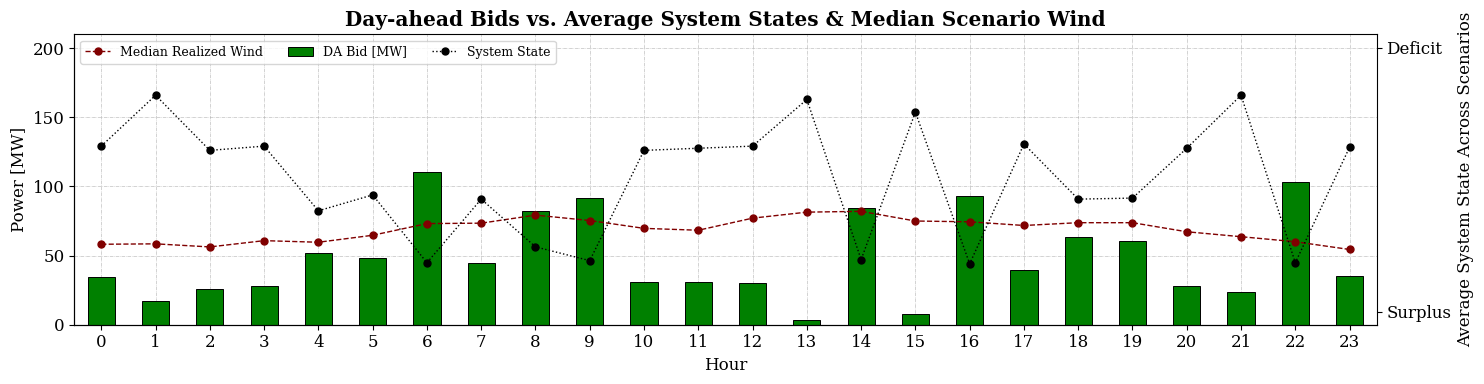

In [22]:
#DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(15, 4))
ax1 = fig.gca()

#plot day-ahead bid for each hour
results_tp['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


#plot average "system state" for each hour
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

#create twinx
ax2 = ax1.twinx()

ax2.plot(average_system_state, color='black', linewidth=1, label='System State', marker='o', markersize=5, linestyle=':')

#plot median realized wind power across scenarios as black line
ax1.plot(results_tp['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')

ax1.set_ylim([0,1.05 *WIND_CAPACITY])

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize='9', ncol=3)

ax1.set_title('Day-ahead Bids vs. Average System States & Median Scenario Wind', weight='bold')
ax1.set_axisbelow(True)
ax2.grid(False)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2.set_ylim([-0.05,1.05])
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Surplus', 'Deficit'])

ax2.set_ylabel('Average System State Across Scenarios')

ax2.spines[['top','right']].set_visible(True)

fig.tight_layout()

#plt.savefig('Figures/Two-price_BID_vs_SYSTEMSTATE_and_WIND.png', dpi=300, bbox_inches='tight')
plt.show()

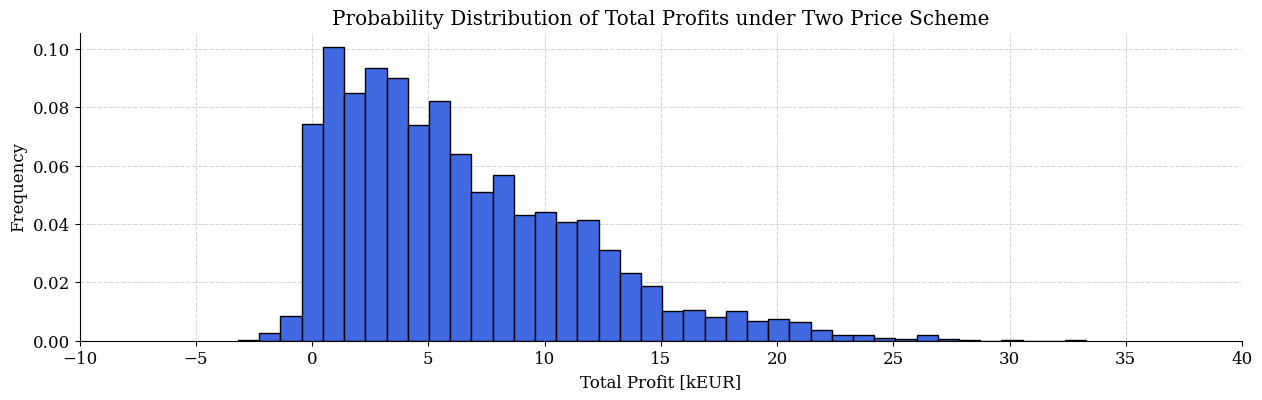

In [23]:
all_scenario_profits = []
for w in range(OMEGA):
    all_scenario_profits.extend(results_tp[w]['Total Profit [EUR]'])

# Plot the probability distribution of profits for all scenarios
plt.figure(figsize=(15, 4))
plt.hist(np.array(all_scenario_profits) * 1e-3, bins=40, density=True, color='royalblue', edgecolor='black', alpha=1)
plt.title('Probability Distribution of Total Profits under Two Price Scheme')
plt.xlabel('Total Profit [kEUR]')
plt.ylabel('Frequency')
plt.xticks(np.arange(-10,45,5))
plt.grid(True)
plt.gca().set_axisbelow(True)
fig.tight_layout()
plt.savefig('Figures/PD in-sample DP.png', dpi=300, bbox_inches='tight')
plt.show()


Similar plot with day-ahead prices instead of realized wind

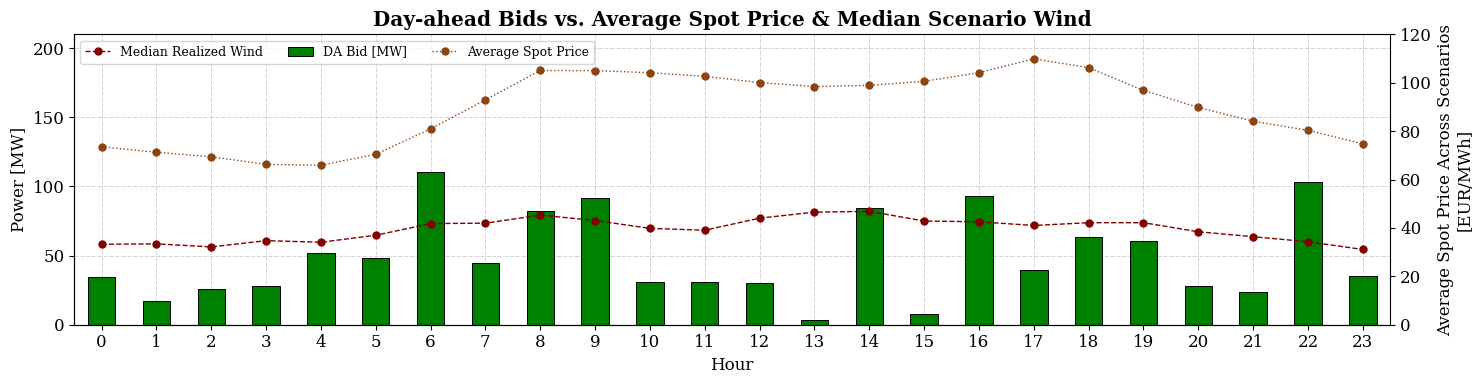

In [27]:
#DA_bids = [p_DA[t].x for t in range(T)]

fig = plt.figure(figsize=(15, 4))
ax1 = fig.gca()

#plot day-ahead bid for each hour
results_tp['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW]')


#plot average "system state" for each hour
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

#create twinx
ax2 = ax1.twinx()

#Average spot price across scenarios
average_spot_price = np.mean([scenarios[str(w)]['Spot Price [EUR/MWh]'] for w in range(OMEGA)], axis=0)

ax2.plot(average_spot_price, color='saddlebrown', linewidth=1, label='Average Spot Price', marker='o', markersize=5, linestyle=':')

#plot median realized wind power across scenarios as black line
ax1.plot(results_tp['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')

ax1.set_ylim([0,1.05 *WIND_CAPACITY])

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize='9', ncol=3)

ax1.set_title('Day-ahead Bids vs. Average Spot Price & Median Scenario Wind', weight='bold')
ax1.set_axisbelow(True)
ax2.grid(False)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2.set_ylim([0,120])

ax2.set_ylabel('Average Spot Price Across Scenarios\n[EUR/MWh]')

ax2.spines[['top','right']].set_visible(True)

fig.tight_layout()

#plt.savefig('Figures/Two-price_BID_vs_SPOT_and_WIND.png', dpi=300, bbox_inches='tight')

plt.show()


# Export optimal day-ahead schedule

In [26]:
#Create dataframe with optimal day-ahead bids for each approach
df = pd.DataFrame(columns=['Hour', 'One-price Bids [MW]', 'Two-price Bids [MW]'])
df['Hour'] = range(T)
df['One-price Bids [MW]'] = results_op['Summary']['DA Bid [MW]'].values
df['Two-price Bids [MW]'] = results_tp['Summary']['DA Bid [MW]'].values
df.set_index('Hour', inplace=True)

df.to_csv('Data/Optimal_DA_bids.csv')

df

,One-price Bids [MW],Two-price Bids [MW]
Hour,,
0,0.0,34.429065
1,0.0,17.363054
2,0.0,25.516105
3,0.0,27.733224
4,0.0,52.012413
5,0.0,48.027292
6,200.0,110.630951
7,0.0,44.485352
8,200.0,82.469291


## Plotting profitability

In [ ]:
## Probability density functions and distributions of the data: 
data = pd.DataFrame(day_total_profits_tp)

# Calculate Coefficient of Variation
cv_tp_day = np.std(day_total_profits_tp) / np.mean(day_total_profits_tp)
cv_op_day = np.std(day_total_profits_op) / np.mean(day_total_profits_op)

print('Coefficient of variation two-price scheme:',cv_tp_day)
print('Coefficient of variation one-price scheme:',cv_op_day)

fig = plt.figure(figsize=(6, 3))
std=np.std(day_total_profits_op)
mu = np.mean(day_total_profits_op)

# 1-price
data = np.array(day_total_profits_op) 
x = np.linspace(np.min(data), np.max(data), 250)
#x = np.linspace(mu - 3*std, mu + 3*std, 250) 

# Fit a normal distribution to the data
dist = norm.fit(data)

# Calculate the probability density function (PDF) at each x value
pdf = norm.pdf(x, loc=dist[0], scale=dist[1])
cdf = norm.cdf(x, loc=dist[0], scale=dist[1])
plt.plot(x, pdf, label = '1-price')

# Two-price
data_tp = np.array(day_total_profits_tp) 

# Define a range of values for the PDF (adjust as needed)
x = np.linspace(np.min(data), np.max(data), 250)

# Fit a normal distribution to the data
dist = norm.fit(data_tp)

# Calculate the probability density function (PDF) at each x value
pdf_tp = norm.pdf(x, loc=dist[0], scale=dist[1])
cdf_tp = norm.cdf(x, loc=dist[0], scale=dist[1])
plt.plot(x, pdf_tp, label = '2-price')

plt.xlabel("Scenario profit")
plt.ylabel("Density")
plt.title("PDFs of profits for scenario profits")
plt.legend()
plt.savefig('Figures/PDF_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot the pdf/cdf

fig = plt.figure(figsize=(6, 3))
plt.plot(x, cdf, label = '1-price')
plt.plot(x, cdf_tp, label = '2-price')

plt.xlabel("Scenario profit")
plt.ylabel("Probablity")
plt.title("CDFs of profits for scenario profits")

plt.legend()
plt.savefig('Figures/CDF_comparison.png', dpi=300, bbox_inches='tight')
plt.show()